In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Sector_Exposure import Rate_Exposures
from Exposure_Report import Exposure
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest

In [26]:

def closest_combos(combo, df, in_index = False):

    assert isinstance(combo, tuple)
    
    min_error = 100
    errors = {}

    for rates in df.index:
        
        ry_error = abs(combo[0] - rates[0])
        yc_error = abs(combo[1] - rates[1])
        error = ry_error + yc_error
         
        errors[rates] = error
        
        if error <= min_error and error > 0:
            min_error = error
    
    mins = list(filter(lambda x: errors[x]==min_error, errors))
    
    if in_index:
        mins.append(combo)
    
    if len(mins) <= 2:
        
        more_mins = list(filter(lambda x: errors[x]==min_error+1, errors))
        
        extended = list( set(mins).union(set(more_mins)) )
        
        if len(extended) <= 3:
            
            even_more_mins = list(filter(lambda x: errors[x]==min_error+2, errors))
            
            return list( set(more_mins).union(set(even_more_mins)) )
        
        return extended
    
    return mins

def first_day_each_month(df):

    current_month = df.index[0].month

    indices = []

    for num, d in enumerate(df.index):
            
        if d.month != current_month:
            
            if d.month == 8 and d.year == 2018:
                pass
            elif d.month == 8 and d.year == 2017:
                pass
            else:
                indices.append(num)
                current_month = d.month
                
    return indices


In [88]:


cutoff = .7

#sector_df = pd.read_csv("2006.csv", index_col="Date")

sector_df = pd.read_csv("macro_data.csv", index_col="Date")

#factor_df = pd.read_csv("regular_factors_and_rates.csv", index_col="Date")

train_df = sector_df[:int(len(sector_df)*cutoff)]
test_df = sector_df[int(len(sector_df)*cutoff):]

forward = 21

compares = ['Real Yield', 'Yield Curve', "inflation", "uncertainty_index", 'market_volume', 'market_volatility', "SP-500"]

exposure_train = Exposure(train_df, 252, forward, ["Real Yield", "Yield Curve"], "SP-500")
for_scores = Exposure(sector_df, 252, forward, ["Real Yield", "Yield Curve"], "SP-500")

""" Scores for testing the training set """
'''
ry_scores_test_monthly = for_scores.monthly_scores['Real Yield']
yc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']
ry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]
yc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]

ry_scores_test_monthly.index = pd.to_datetime(ry_scores_test_monthly.index)
yc_scores_test_monthly.index = pd.to_datetime(yc_scores_test_monthly.index)
'''



"\nry_scores_test_monthly = for_scores.monthly_scores['Real Yield']\nyc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']\nry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]\nyc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]\n\nry_scores_test_monthly.index = pd.to_datetime(ry_scores_test_monthly.index)\nyc_scores_test_monthly.index = pd.to_datetime(yc_scores_test_monthly.index)\n"

In [89]:
sector_labels = {sec : num for num, sec in enumerate(exposure_train.sectors)}
sector_labels_reverse = {num : sec for num, sec in enumerate(exposure_train.sectors)}

train_df = exposure_train.forward_returns_daily
test_df = for_scores.forward_returns_daily.loc[ for_scores.forward_returns_daily.index > train_df.index[-1] ]
X_train = train_df[[f"{i}_scores" for i in exposure_train.compare_against]]
Y_train = train_df[exposure_train.sectors]
X_test = test_df[[f"{i}_scores" for i in exposure_train.compare_against]]
Y_test = test_df[exposure_train.sectors]

best_train = pd.Series([Y_train.loc[d].sort_values().index[-1] for d in Y_train.index], index = Y_train.index)
best_test = pd.Series([Y_test.loc[d].sort_values().index[-1] for d in Y_test.index], index = Y_test.index)

X_train['best_sector'] = best_train
X_test['best_sector'] = best_test

/var/folders/5c/pr4qxx_n549__j7rk3s5rgkc0000gp/T/ipykernel_76206/3482345877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['best_sector'] = best_train
/var/folders/5c/pr4qxx_n549__j7rk3s5rgkc0000gp/T/ipykernel_76206/3482345877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['best_sector'] = best_test


In [92]:

sec_mean_scores_train = {}
sec_mean_scores_test = {}

for sec in X_train.best_sector.unique():
    
    sec_mean_scores_train[sec] = X_train.iloc[:,:-1].loc[ X_train.best_sector == sec].mean().mean()

for sec in X_test.best_sector.unique():
    
    sec_mean_scores_test[sec] = X_test.iloc[:,:-1].loc[ X_test.best_sector == sec].mean().mean()
    

<AxesSubplot:>

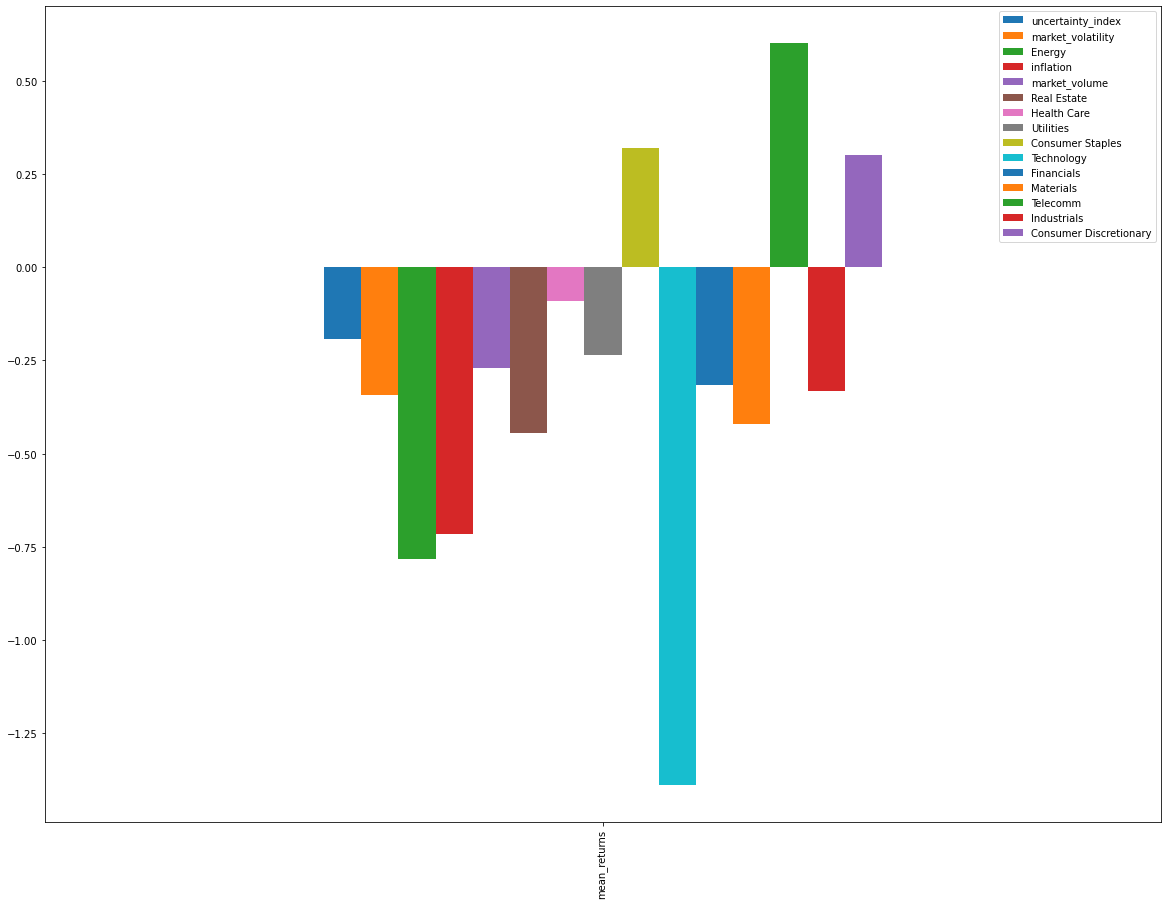

In [91]:


# & (X_train.inflation_scores >= 1)

#industrials = X_train.iloc[:,:-1].loc[ (X_train.best_sector == "Industrials")  ]


#industrials['inflation_scores'].hist()
#train_df.loc[industrials.index]


pd.DataFrame(sec_mean_scores_train, index = ['mean_returns']).plot.bar(figsize = (20,15))



<AxesSubplot:>

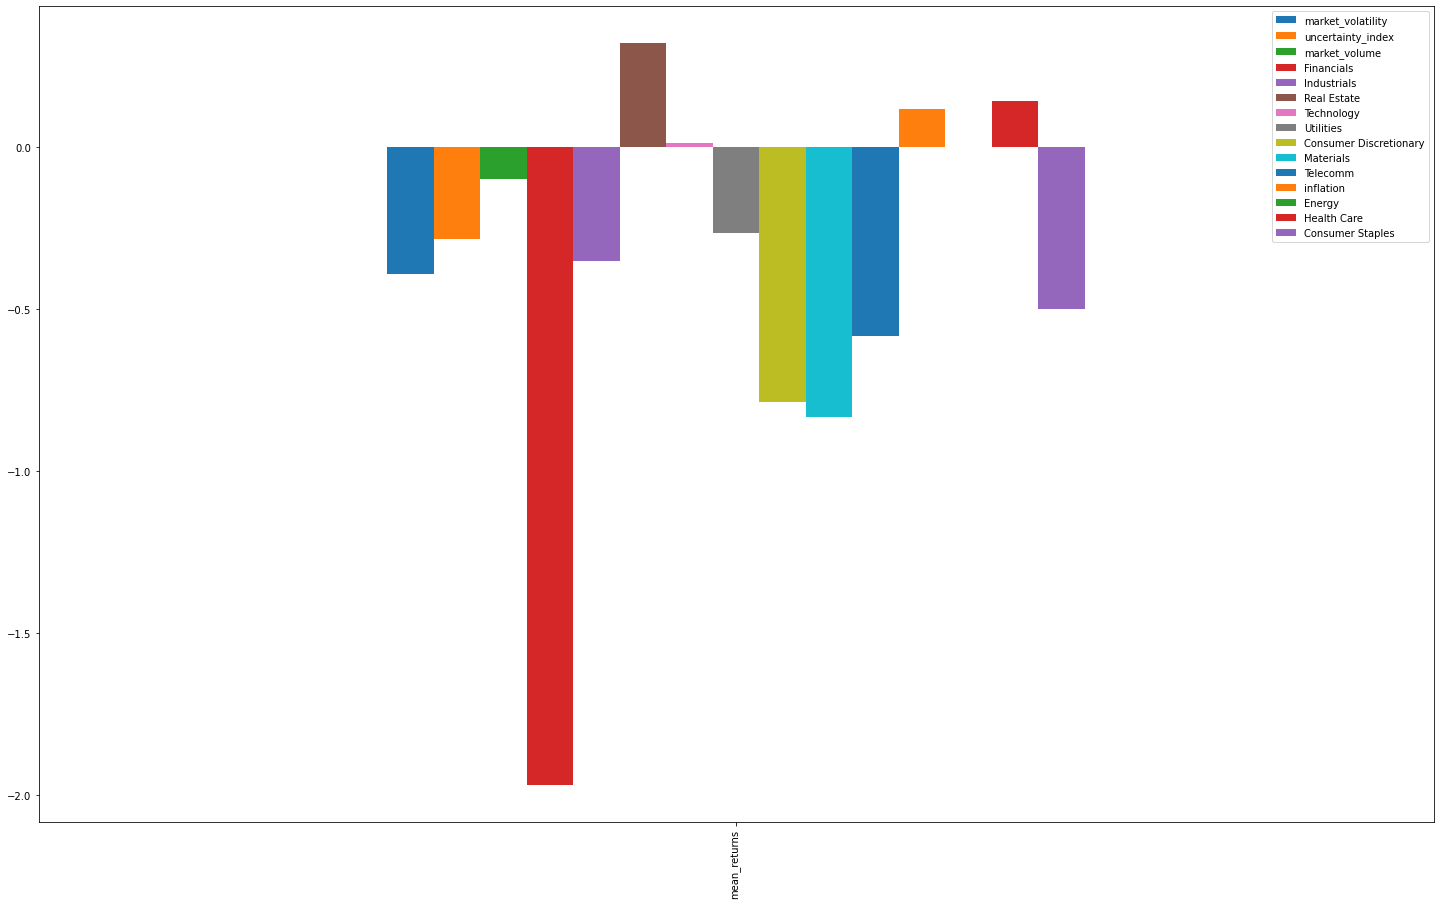

In [94]:



pd.DataFrame(sec_mean_scores_test, index = ['mean_returns']).plot.bar(figsize=(25,15))




<AxesSubplot:>

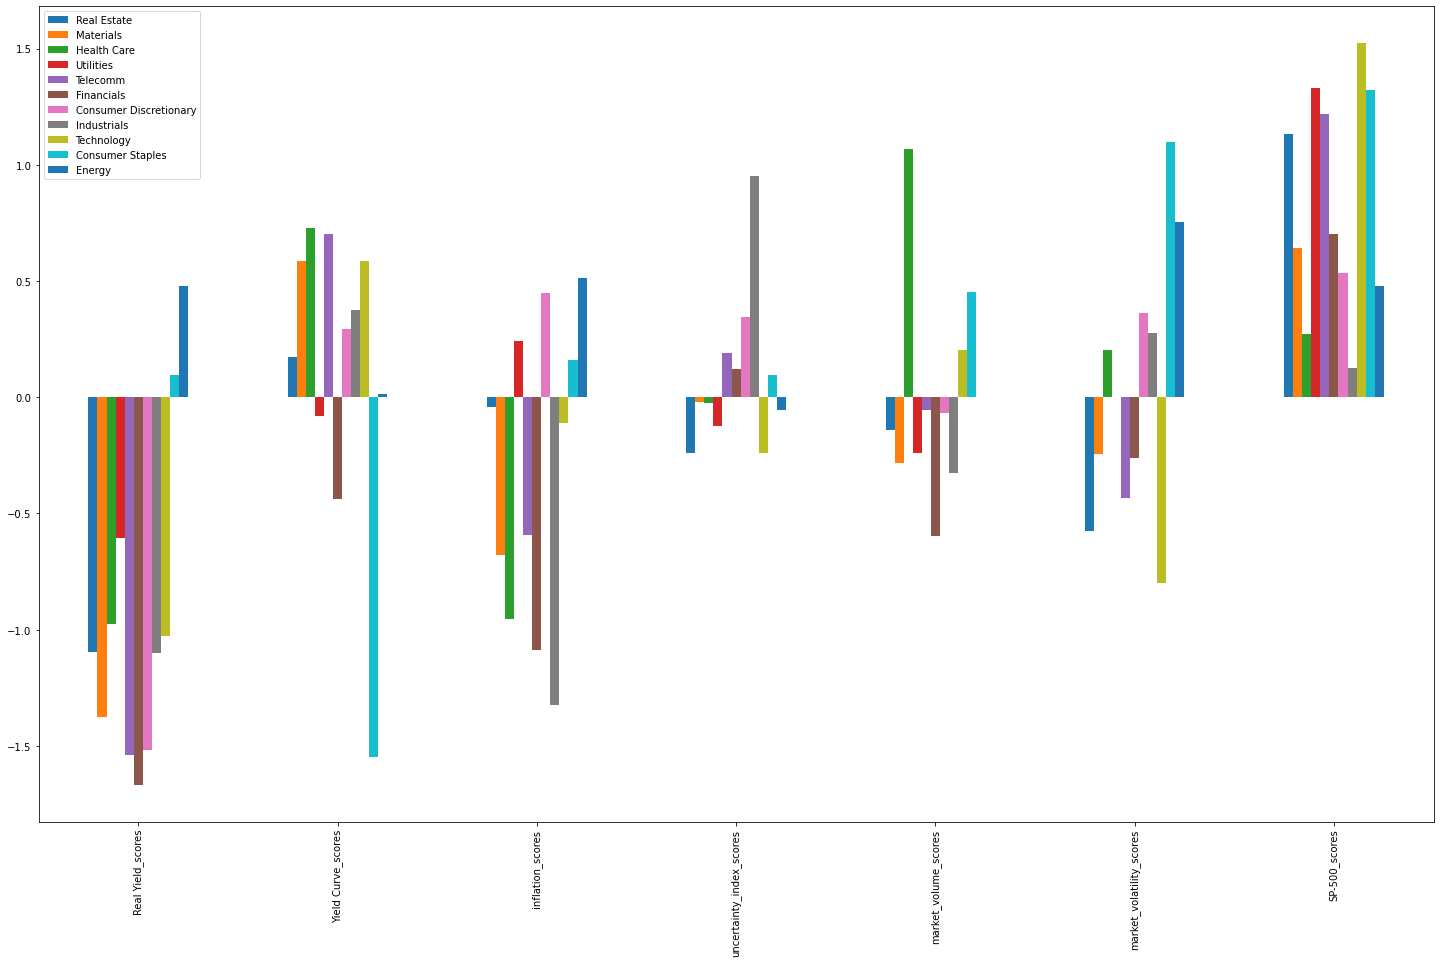

In [82]:


pd.DataFrame(sec_mean_scores_test).plot.bar(figsize=(25,15))


In [52]:



#consideration_df['top_sector'] = [consideration_df.iloc[:,:11].loc[i].sort_values().index[-1] for i in consideration_df.iloc[:,:11].index]
#consideration_df['top_sector_returns'] = [consideration_df.iloc[:,:11].loc[i].sort_values()[-1] for i in consideration_df.iloc[:,:11].index]
#consideration_df['top_sector'] = [sector_labels[i] for i in consideration_df['top_sector']]

#best = pd.Series([sector_labels[i] for i in best], index = best.index)




/var/folders/5c/pr4qxx_n549__j7rk3s5rgkc0000gp/T/ipykernel_76206/2925544931.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = X_train.mean(axis=1)


In [51]:





X_train

/var/folders/5c/pr4qxx_n549__j7rk3s5rgkc0000gp/T/ipykernel_76206/2473483646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['best_sector'] = best


,Real Yield_scores,Yield Curve_scores,inflation_scores,uncertainty_index_scores,market_volume_scores,market_volatility_scores,SP-500_scores,best_sector
Date,,,,,,,,
2011-03-03,-2.0,1.0,3.0,-1.0,2.0,1.0,2.0,Telecomm
2011-03-04,-2.0,1.0,3.0,-1.0,2.0,1.0,1.0,Telecomm
2011-03-07,-2.0,1.0,3.0,1.0,2.0,1.0,1.0,Telecomm
2011-03-08,-1.0,2.0,3.0,0.0,2.0,0.0,2.0,Materials
2011-03-09,-1.0,1.0,2.0,0.0,1.0,0.0,2.0,Materials
...,...,...,...,...,...,...,...,...
2018-10-15,3.0,0.0,0.0,1.0,0.0,-2.0,-2.0,Real Estate
2018-10-16,3.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,Real Estate
2018-10-17,3.0,0.0,1.0,-1.0,0.0,-1.0,-1.0,Real Estate


In [44]:

predicted_best_sector = []

for i in X_test.index:
    
    closest_combos(tuple(i), X_train)



TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [249]:


""" Better version of train_results_df (above) that is used for the Baysian Updating after Predictions """
real_train_results = exposure.forward_returns_monthly.copy()
real_train_results.index = pd.to_datetime(real_train_results.index)
real_train_results['scores'] = [(i,j) for i,j in zip(real_train_results['Real Yield_scores'], real_train_results['Yield Curve_scores'])]
real_train_results = real_train_results.dropna()
real_train_results = real_train_results.drop(columns = ['Real Yield_scores', 'Yield Curve_scores'])



In [260]:


indies = first_day_each_month(ry_scores_test_monthly)
firsts_of_the_month = ry_scores_test_monthly.index[indies]



In [252]:


""" Data Below is the actual data that occured, to test against training data """
#actual_results_exposure = Exposure(test_df, 252, forward, ['Real Yield', 'Yield Curve'])
actual_returns = for_scores.forward_returns_monthly.iloc[:,:-2].loc[for_scores.forward_returns_monthly.index > train_df.index[-1]]
actual_returns.index = pd.to_datetime(actual_returns.index)
actual_returns = actual_returns.loc[ (actual_returns.index >= ry_scores_test_monthly.index[0]) & (actual_returns.index <= ry_scores_test_monthly.index[-1])]
actual_returns['Real Yield_scores'] = ry_scores_test_monthly
actual_returns['Yield Curve_scores'] = yc_scores_test_monthly
actual_returns['scores'] = [(i,j) for i,j in zip(actual_returns['Real Yield_scores'], actual_returns['Yield Curve_scores'])]
actual_returns = actual_returns.drop(columns = ["Real Yield_scores", 'Yield Curve_scores'])




In [262]:


predicted_best_sector = []
predicted_worst_sector = []
exp_ret_top = []
exp_ret_bottom = []
scores = []
top_n_sectors = 1
bottom_n_sectors = 1

for num, (ry, yc) in enumerate(zip(ry_scores_test_monthly, yc_scores_test_monthly)):
    
    if ((ry, yc) == real_train_results['scores']).any():
        
        combos = closest_combos((ry, yc), True)
    else:
        combos = closest_combos((ry, yc))
    
    #top_secs = train_results_df.loc[combos].mean().sort_values()[-top_n_sectors:]
    top_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-top_n_sectors:]
    bottom_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[:bottom_n_sectors]
    
    if len(top_secs) == 1 and u.en in top_secs.index:
        #predicted_best_sector.append([real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values().index[-2]])
        predicted_best_sector.append(real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-top_n_sectors-1:].index.to_list())
    else:
        predicted_best_sector.append(top_secs.index.to_list())
    
    if len(bottom_secs) == 1 and u.en in bottom_secs.index:
        
        predicted_worst_sector.append(real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[:bottom_n_sectors+1].index.to_list())
    else:
        predicted_worst_sector.append(bottom_secs.index.to_list())
    

    scores.append((ry,yc))
    
    update_index = ry_scores_test_monthly.index[num]
    
    if update_index <= actual_returns.index[-1]:
        # .drop(columns = ["SP-500"])
        real_train_results = pd.concat([real_train_results, pd.DataFrame(actual_returns.loc[update_index]).T])

performance_report = pd.DataFrame(index = ry_scores_test_monthly.index)
performance_report['scores'] = scores
performance_report['pred_top_secs'] = predicted_best_sector
performance_report['pred_bottom_secs'] = predicted_worst_sector
performance_report.index = pd.to_datetime(performance_report.index)



In [283]:


performance_report.pred_top_secs.value_counts()


[Technology]            478
[Health Care]           111
[Utilities]              91
[Utilities, Energy]      61
[Financials, Energy]     47
[Real Estate]            25
[Financials]             24
[Telecomm]               16
[Industrials]            14
[Consumer Staples]       11
[Materials, Energy]       6
[Telecomm, Energy]        5
[Technology, Energy]      4
[Materials]               1
Name: pred_top_secs, dtype: int64

In [284]:
from datetime import timedelta
#firsts_of_the_month

bruh = performance_report.loc[firsts_of_the_month[15] - timedelta(days = 20) :firsts_of_the_month[15]].pred_top_secs.to_list()

ok = []

for i in bruh:
    
    for sec in i:
        ok.append(sec)


ok = pd.Series(ok).value_counts().index[0]

ok

'Technology'

In [270]:

daily_actual_returns = for_scores.forward_returns_daily.copy().drop(columns = ["Real Yield_scores", "Yield Curve_scores"])

daily_actual_returns.index = pd.to_datetime(daily_actual_returns.index)

inds = first_day_each_month(daily_actual_returns)

daily_actual_returns = daily_actual_returns.loc[daily_actual_returns.index[inds]].dropna()

daily_actual_returns = daily_actual_returns.loc[ daily_actual_returns.index >= performance_report.index[0] ]

daily_actual_returns

,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy
2018-12-03,0.013796,-0.017844,0.007084,0.018521,-0.000600,-0.009632,-0.026379,0.046060,0.055220,0.023805,-0.016856
2019-01-02,-0.027231,0.031276,0.014853,-0.022938,-0.016345,0.000612,-0.009258,0.009716,-0.024979,0.055735,0.010380
2019-02-01,-0.003442,0.022474,0.000503,-0.010871,-0.023137,-0.016118,0.031316,-0.012106,0.010890,-0.013964,-0.010604
2019-03-01,0.000022,-0.024248,0.019025,0.027535,-0.021449,-0.043672,0.029190,0.005026,0.013624,0.035160,-0.009316
2019-04-01,-0.006547,-0.008046,0.016849,-0.001966,-0.056453,0.035242,0.021426,0.019581,-0.011389,-0.030378,-0.041053
2019-05-01,-0.009896,-0.013975,-0.007017,0.031437,0.031221,-0.005631,-0.025655,0.012710,0.039578,0.046981,-0.036483
2019-06-03,-0.005999,-0.018531,0.022011,-0.032666,-0.015349,-0.010677,0.045180,0.012253,-0.052886,-0.056932,-0.023800
2019-07-05,-0.007580,-0.001929,-0.013651,0.017255,-0.010279,-0.002437,0.007329,0.009322,0.010422,0.022043,-0.025446
2019-08-01,-0.021965,-0.004334,0.014134,0.032894,0.000239,-0.022158,-0.002041,0.000070,0.045491,0.052605,-0.056991
2019-09-03,0.002888,0.007408,-0.008511,-0.006583,-0.018258,0.022661,0.006983,-0.007507,0.006908,-0.029973,0.005723


In [186]:


new_rets = sector_df.copy()
new_rets.index = pd.to_datetime(new_rets.index)

In [209]:


#daily_actual_returns.index == actual_returns.index



daily_actual_returns.loc[actual_returns.index[5]].sort_values()


#daily_actual_returns.loc[actual_returns.index[5]][-top_n_sectors:]

#daily_actual_returns


Energy                   -0.036483
Technology               -0.025655
Industrials              -0.013975
Materials                -0.009896
Consumer Discretionary   -0.007017
Financials               -0.005631
Telecomm                  0.012710
Health Care               0.031221
Consumer Staples          0.031437
Utilities                 0.039578
Real Estate               0.046981
Name: 2019-05-01 00:00:00, dtype: float64

In [285]:

actual_secs = []
actual_bottom_secs = []
actual_ret = []
predicted_sector_performance = []
predicted_bottom_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    '''
        dex = new_rets.loc[ (new_rets.index.month == d.month) & (new_rets.index.year == d.year)].index[0]
    if len(new_rets.loc[dex:]) >= forward:
        top_actual_secs = new_rets.loc[dex:].iloc[0:forward].pct_change().cumsum().iloc[-1][:-3].sort_values()
        actual_secs.append(top_actual_secs.index[-top_n_sectors:].to_list())
        actual_bottom_secs.append(top_actual_secs.index[:top_n_sectors].to_list())
        actual_ret.append(top_actual_secs[-top_n_sectors:].mean())
    
        predicted_sector_performance.append(top_actual_secs[list(performance_report['pred_top_secs'].loc[d])].mean())
        predicted_bottom_sector_performance.append(top_actual_secs[list(performance_report['pred_bottom_secs'].loc[d])].mean())
    '''
    
    top_actual_secs = daily_actual_returns.loc[d]
    
    actual_secs.append(top_actual_secs.sort_values().index[-top_n_sectors:].to_list())
    actual_bottom_secs.append(top_actual_secs.sort_values().index[:top_n_sectors].to_list())
    actual_ret.append(top_actual_secs.sort_values()[-top_n_sectors:].mean())
    predicted_sector_performance.append(top_actual_secs[list(performance_report['pred_top_secs'].loc[d])].mean())
    predicted_bottom_sector_performance.append(top_actual_secs[list(performance_report['pred_bottom_secs'].loc[d])].mean())
    
    

    
    

actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_bottom_secs = pd.Series(actual_bottom_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)
predicted_sector_performance = pd.Series(predicted_sector_performance, index = actual_returns.index)
predicted_bottom_sector_performance = pd.Series(predicted_bottom_sector_performance, index = actual_returns.index)

performance_report['actual_top_secs'] = actual_secs
performance_report['actual_bottom_secs'] = actual_bottom_secs
performance_report['actual_rets'] = actual_ret
performance_report['predicted_sector_performance'] = predicted_sector_performance
performance_report['predicted_bottom_sector_performance'] = predicted_bottom_sector_performance
performance_report = performance_report.dropna()




KeyError: Timestamp('2018-11-06 00:00:00')

In [217]:



performance_report





,scores,pred_top_secs,pred_bottom_secs,actual_top_secs,actual_bottom_secs,actual_rets,predicted_sector_performance,predicted_bottom_sector_performance
2018-12-03,"(2.0, -2.0)",[Consumer Discretionary],[Telecomm],[Utilities],[Technology],0.055220,0.007084,0.046060
2019-01-02,"(1.0, -2.0)",[Consumer Discretionary],[Financials],[Real Estate],[Materials],0.055735,0.014853,0.000612
2019-02-01,"(-0.0, -1.0)",[Technology],[Telecomm],[Technology],[Health Care],0.031316,0.031316,-0.012106
2019-03-01,"(-1.0, -1.0)",[Health Care],[Utilities],[Real Estate],[Financials],0.035160,-0.021449,0.013624
2019-04-01,"(-2.0, -1.0)","[Technology, Energy]",[Real Estate],[Financials],[Health Care],0.035242,-0.009813,-0.030378
2019-05-01,"(-2.0, -0.0)",[Consumer Discretionary],[Telecomm],[Real Estate],[Energy],0.046981,-0.007017,0.012710
2019-06-03,"(-2.0, -1.0)",[Technology],[Health Care],[Technology],[Real Estate],0.045180,0.045180,-0.015349
2019-07-05,"(-3.0, 1.0)",[Health Care],"[Energy, Materials]",[Real Estate],[Energy],0.022043,-0.010279,-0.016513
2019-08-01,"(-2.0, -1.0)",[Technology],[Health Care],[Real Estate],[Energy],0.052605,-0.002041,0.000239
2019-09-03,"(-3.0, -3.0)",[Telecomm],[Financials],[Financials],[Real Estate],0.022661,-0.007507,0.022661
